# Modelling the future resident population

A simplicistic model could be:

$ p(a=0,y) = br(y) $

$ p(a,y) = p(a-1,y-1) * sr(a, y-1)$

$ p(a=100+, y) = p(a=99,y-1) * sr(a, y-1) + p(a=100,y-1) * sr_{100+}(a, y-1)

Where:
- $p(a, y)$ is the resident population of age $a$ in year $y$
- $br(y)$ is the annual new births in year $y-1$
- $sr(a, y)$ is the annual survival rate in year $y$ (which could also be positive in case of incoming migrants) for people aged $a$ in year $y$
- $sr_{100+}(a, y)$ is the annual survival rate for the 100+ aged group

I will need to make some assumptions:
1. no significant new migrations
2. $sr$ follows a linear trend wrt the years (e.g., improve in care and technology), overlooking heat waves and covid that should be just weighed in the linear regression
3. for $br$ I need to explore the previous trend and make some extrapolation, likely linear

As soon as I see limits in these assumptions I will try to improve the complexity of the model as ideas in the "Follow-up" section at the end: we need to start with a lean model to have a full pipeline.

In [1]:
from istatapi import discovery, retrieval
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Remake table: index-Age, column-Year of Observation, value-population
ds = discovery.DataSet(dataflow_identifier="DCIS_RICPOPRES2011")
ds.set_filters(tipo_dato="JAN", itter107 ="IT", stacivx="99", sesso="9")
df = retrieval.get_data(ds)

ds = discovery.DataSet(dataflow_identifier="DCIS_POPRES1")
ds.set_filters(itter107 ="IT", stacivx="99", sesso="9")
df1 = retrieval.get_data(ds)

df1["CITTADINANZA"] = 'TOTAL'
dfplot = pd.concat([
    df[["TIME_PERIOD", "CLASSE_ETA", "OBS_VALUE", "CITTADINANZA"]], 
    df1[df1.TIME_PERIOD>pd.to_datetime('2019-01-01')].rename(columns={'ETA':'CLASSE_ETA'})[["TIME_PERIOD", "CLASSE_ETA", "OBS_VALUE", "CITTADINANZA"]]
])

dfplot = (
    dfplot
    .replace("Y_GE100", "Y100")
    .query("CITTADINANZA=='TOTAL'")
    .query("CLASSE_ETA!='TOTAL'")
    .assign(eta= lambda x: x["CLASSE_ETA"].str.split("Y").str[-1].astype(int))
    .assign(year= lambda x: x["TIME_PERIOD"].dt.year)
    # aggregate eta by 5 years
    .assign(eta_group= lambda x: x["eta"] // 10 * 10)
    [["year", "eta", "OBS_VALUE"]]
    #.groupby(["TIME_PERIOD", "eta_group"]).sum()
    .sort_values(["eta", "year"])
    .reset_index()
)
dfp = dfplot[['year', 'eta', 'OBS_VALUE']].pivot(index='eta', columns='year', values='OBS_VALUE')
dfp

year    2002    2003    2004    2005    2006    2007    2008    2009    2010  \
eta                                                                            
0     523007  535656  542323  558500  551127  556884  560700  570791  562322   
1     529233  526577  538020  545596  559067  552870  560028  563021  569963   
2     528131  533126  531043  540860  548487  560347  556146  562640  564317   
3     518790  530847  537507  535545  543768  550808  563000  559193  564536   
4     515957  522484  534064  542329  540131  545782  554754  565127  560899   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
96     16400   17254   17494   20055   21122   24346   25054   27290   28086   
97     10981   11797   11980   12758   14071   15356   17559   18179   20203   
98      6838    7643    7901    8505    8725    9888   10871   12349   12977   
99      4866    4702    4971    5411    5682    5945    6643    7469    8547   
100     6121    7093    7200    8095    8538    9122    9575   10158   11297   

year    2011  ...    2013    2014    2015    2016    2017    2018    2019  \
eta           ...                                                           
0     553218  ...  534047  512140  499940  482977  469956  455066  431007   
1     561694  ...  539163  533916  511448  499707  482975  470412  455746   
2     569064  ...  554476  540449  532895  510117  499100  482810  470813   
3     565219  ...  563518  556034  539900  531804  508569  498644  482946   
4     565563  ...  570533  565065  555647  539174  530684  507352  498240   
..       ...  ...     ...     ...     ...     ...     ...     ...     ...   
96     29780  ...   23522   19375   18513   24270   37624   38707   39836   
97     21305  ...   21639   17158   14483   13246   17960   27307   28842   
98     14740  ...   16125   15362   12386   10142    9607   12695   19650   
99      9207  ...   10705   11153   10728    8258    7145    6689    8985   
100    13106  ...   16205   17252   18420   17698   16558   14984   14132   

year    2020    2021    2022  
eta                           
0     414974  404956  400626  
1     436785  423269  407634  
2     457314  443571  425183  
3     471696  464239  444638  
4     483769  480475  464753  
..       ...     ...     ...  
96     41447   40293   40802  
97     29302   29016   29171  
98     20560   20113   20528  
99     13421   13635   13742  
100    14804   17177   19714  

[101 rows x 21 columns]

In [3]:
dfpp = pd.DataFrame({col: [np.nan] * len(dfp.index) for col in dfp.columns})
for year in range(2002+1, 2022+1):
    prev_year = dfp[year-1].shift(1).to_numpy()
    dfpp[year] = (dfp[year] - prev_year)/ prev_year
dfpp = dfpp.iloc[1:-1]
dfpp = dfpp.drop(columns=[2002])
dfpp

2003      2004      2005      2006      2007      2008      2009  \
1   0.006826  0.004413  0.006035  0.001015  0.003163  0.005646  0.004139   
2   0.007356  0.008481  0.005279  0.005299  0.002290  0.005925  0.004664   
3   0.005143  0.008218  0.008478  0.005377  0.004232  0.004735  0.005479   
4   0.007120  0.006060  0.008971  0.008563  0.003704  0.007164  0.003778   
5   0.007592  0.008182  0.006784  0.009140  0.006976  0.007593  0.005785   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.245960 -0.263653 -0.233332 -0.247680 -0.231303 -0.232070 -0.231649   
96 -0.261482 -0.280408 -0.255955 -0.271404 -0.251054 -0.253212 -0.256484   
97 -0.280671 -0.305668 -0.270721 -0.298379 -0.272986 -0.278773 -0.274407   
98 -0.303980 -0.330253 -0.290067 -0.316115 -0.297278 -0.292068 -0.296714   
99 -0.312372 -0.349601 -0.315150 -0.331922 -0.318625 -0.328176 -0.312943   

        2010      2011      2012      2013      2014      2015      2016  \
1  -0.001451 -0.001117 -0.002708  0.003380 -0.000245 -0.001351 -0.000466   
2   0.002302 -0.001577 -0.001337  0.004995  0.002385 -0.001912 -0.002602   
3   0.003370  0.001598 -0.001633  0.004590  0.002810 -0.001016 -0.002047   
4   0.003051  0.001819  0.000717  0.004221  0.002745 -0.000696 -0.001345   
5   0.002272  0.002077  0.001547  0.004305  0.001975 -0.000265 -0.001139   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.215476 -0.209066 -0.213524 -0.233036 -0.227982 -0.218621 -0.242551   
96 -0.239686 -0.218188 -0.223668 -0.258636 -0.240494 -0.235916 -0.257548   
97 -0.259692 -0.241437 -0.234520 -0.280427 -0.270555 -0.252490 -0.284503   
98 -0.286154 -0.270405 -0.259986 -0.292639 -0.290078 -0.278121 -0.299731   
99 -0.307879 -0.290514 -0.267910 -0.321007 -0.308341 -0.301653 -0.333280   

        2017      2018      2019      2020      2021      2022  
1  -0.000004  0.000970  0.001494  0.013406  0.019989  0.006613  
2  -0.001215 -0.000342  0.000852  0.003441  0.015536  0.004522  
3  -0.003035 -0.000914  0.000282  0.001875  0.015143  0.002405  
4  -0.002106 -0.002393 -0.000810  0.001704  0.018612  0.001107  
5  -0.001593 -0.001824 -0.000461  0.001814  0.019739 -0.003728  
..       ...       ...       ...       ...       ...       ...  
95 -0.223514 -0.232952 -0.223105 -0.221649 -0.253108 -0.234357  
96 -0.237470 -0.249195 -0.237238 -0.244812 -0.275944 -0.256252  
97 -0.259992 -0.274213 -0.254863 -0.264434 -0.299925 -0.276028  
98 -0.274724 -0.293151 -0.280404 -0.287151 -0.313596 -0.292528  
99 -0.295504 -0.303737 -0.292241 -0.316997 -0.336819 -0.316760  

[99 rows x 20 columns]

## Birth rate

In [4]:
dfp

year    2002    2003    2004    2005    2006    2007    2008    2009    2010  \
eta                                                                            
0     523007  535656  542323  558500  551127  556884  560700  570791  562322   
1     529233  526577  538020  545596  559067  552870  560028  563021  569963   
2     528131  533126  531043  540860  548487  560347  556146  562640  564317   
3     518790  530847  537507  535545  543768  550808  563000  559193  564536   
4     515957  522484  534064  542329  540131  545782  554754  565127  560899   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
96     16400   17254   17494   20055   21122   24346   25054   27290   28086   
97     10981   11797   11980   12758   14071   15356   17559   18179   20203   
98      6838    7643    7901    8505    8725    9888   10871   12349   12977   
99      4866    4702    4971    5411    5682    5945    6643    7469    8547   
100     6121    7093    7200    8095    8538    9122    9575   10158   11297   

year    2011  ...    2013    2014    2015    2016    2017    2018    2019  \
eta           ...                                                           
0     553218  ...  534047  512140  499940  482977  469956  455066  431007   
1     561694  ...  539163  533916  511448  499707  482975  470412  455746   
2     569064  ...  554476  540449  532895  510117  499100  482810  470813   
3     565219  ...  563518  556034  539900  531804  508569  498644  482946   
4     565563  ...  570533  565065  555647  539174  530684  507352  498240   
..       ...  ...     ...     ...     ...     ...     ...     ...     ...   
96     29780  ...   23522   19375   18513   24270   37624   38707   39836   
97     21305  ...   21639   17158   14483   13246   17960   27307   28842   
98     14740  ...   16125   15362   12386   10142    9607   12695   19650   
99      9207  ...   10705   11153   10728    8258    7145    6689    8985   
100    13106  ...   16205   17252   18420   17698   16558   14984   14132   

year    2020    2021    2022  
eta                           
0     414974  404956  400626  
1     436785  423269  407634  
2     457314  443571  425183  
3     471696  464239  444638  
4     483769  480475  464753  
..       ...     ...     ...  
96     41447   40293   40802  
97     29302   29016   29171  
98     20560   20113   20528  
99     13421   13635   13742  
100    14804   17177   19714  

[101 rows x 21 columns]

In [5]:
dfp.columns

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
           dtype='int64', name='year')

In [6]:
start_year = min(dfp.columns)
end_year = 2100
historical_data = dfp.T[0].values.tolist()
historical_data += [ None for _ in range(end_year - start_year - len(historical_data)+1) ]
br_df = pd.DataFrame(historical_data, index=range(start_year, end_year+1), columns=["Historical"])
br_df.plot()

In [7]:
# Stable scenario: 
br_last = br_df.dropna().iat[-1, 0]
br_df['Predict. (Stable)'] = [ 
                              None if year<=2022 else br_last 
                              for year in range(start_year, end_year+1) 
]
br_df.plot()

In [8]:
# Following the drop from 2019
m = (br_df.at[2022,"Historical"]-br_df.at[2009,"Historical"]) / (2022-2009)
br_df['Predict. (Trend)'] = [ 
                              None if year<2009 else br_df.at[2022,"Historical"] + m*(year-2022)
                              for year in range(start_year, end_year+1) 
]
br_df.plot()

In [9]:
# Intermediate scenario:
mm = m/2
br_df['Predict. (Intermediate)'] = [ 
                              None if year<2023 else br_df.at[2022,"Historical"] + mm*(year-2022)
                              for year in range(start_year, end_year+1) 
]
br_df.plot()

> Ooops! The number newborns are getting negative with linear extrapolation. For the moment I will simply use the "Stable" prediction, and come back later on this assumption to make some smoothening of the negative trend.

## Survival Rate

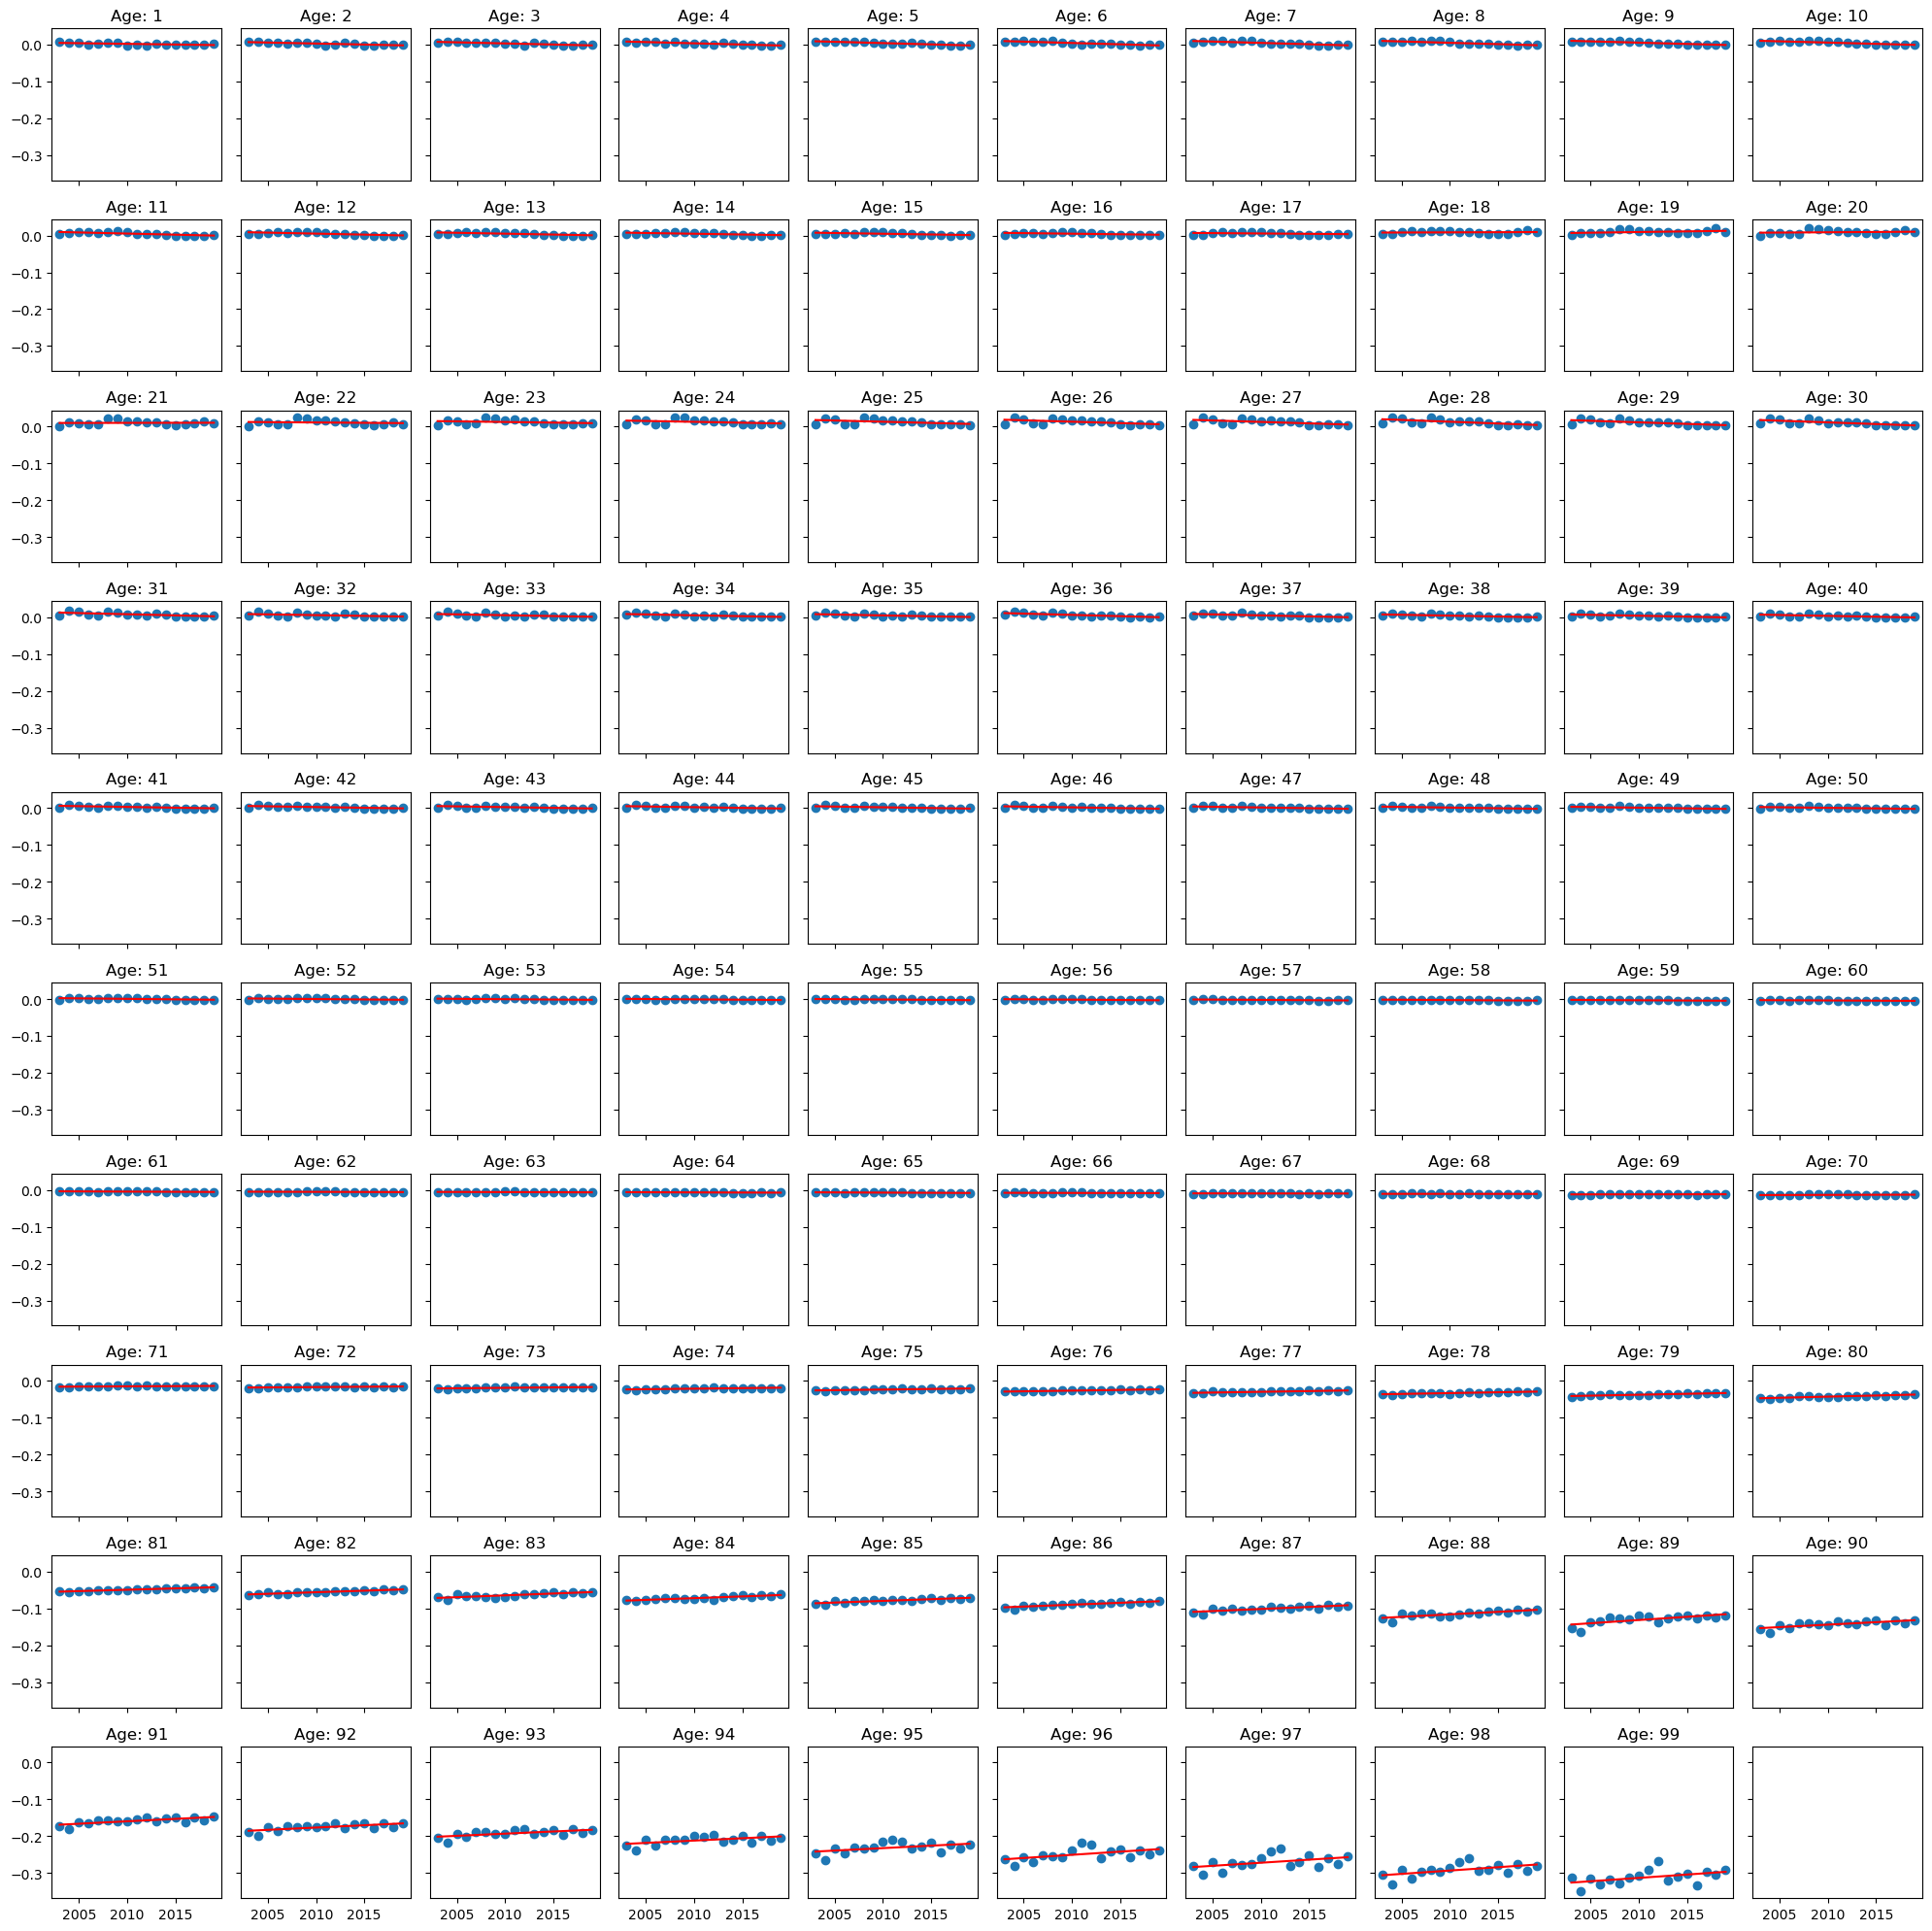

In [10]:
# Excluding the COVID-19 years and fitting a linear trend
dfsr = dfpp[list(range(2003, 2020))]
# fit a linear trend for every age group: linear regression of the survival rate from 1 to 99 (lr_sr_1_99)
lr_sr_1_99 = dfsr.apply(lambda x: np.polyfit(x.index, x, 1), axis=1)
# Plot coefficients for every age group and the linear trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharey=True, sharex=True)
for i, age in enumerate(dfsr.index):
    ax = axs.flatten()[i]
    ax.scatter(dfsr.columns, dfsr.loc[age].values, label=age)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red")
plt.tight_layout()
plt.show()

> I have better to apply some t-test to check if the survival rate is significantly different from the previous years: I guess for <60 years it is non significant. But I will do that in a second analysis.

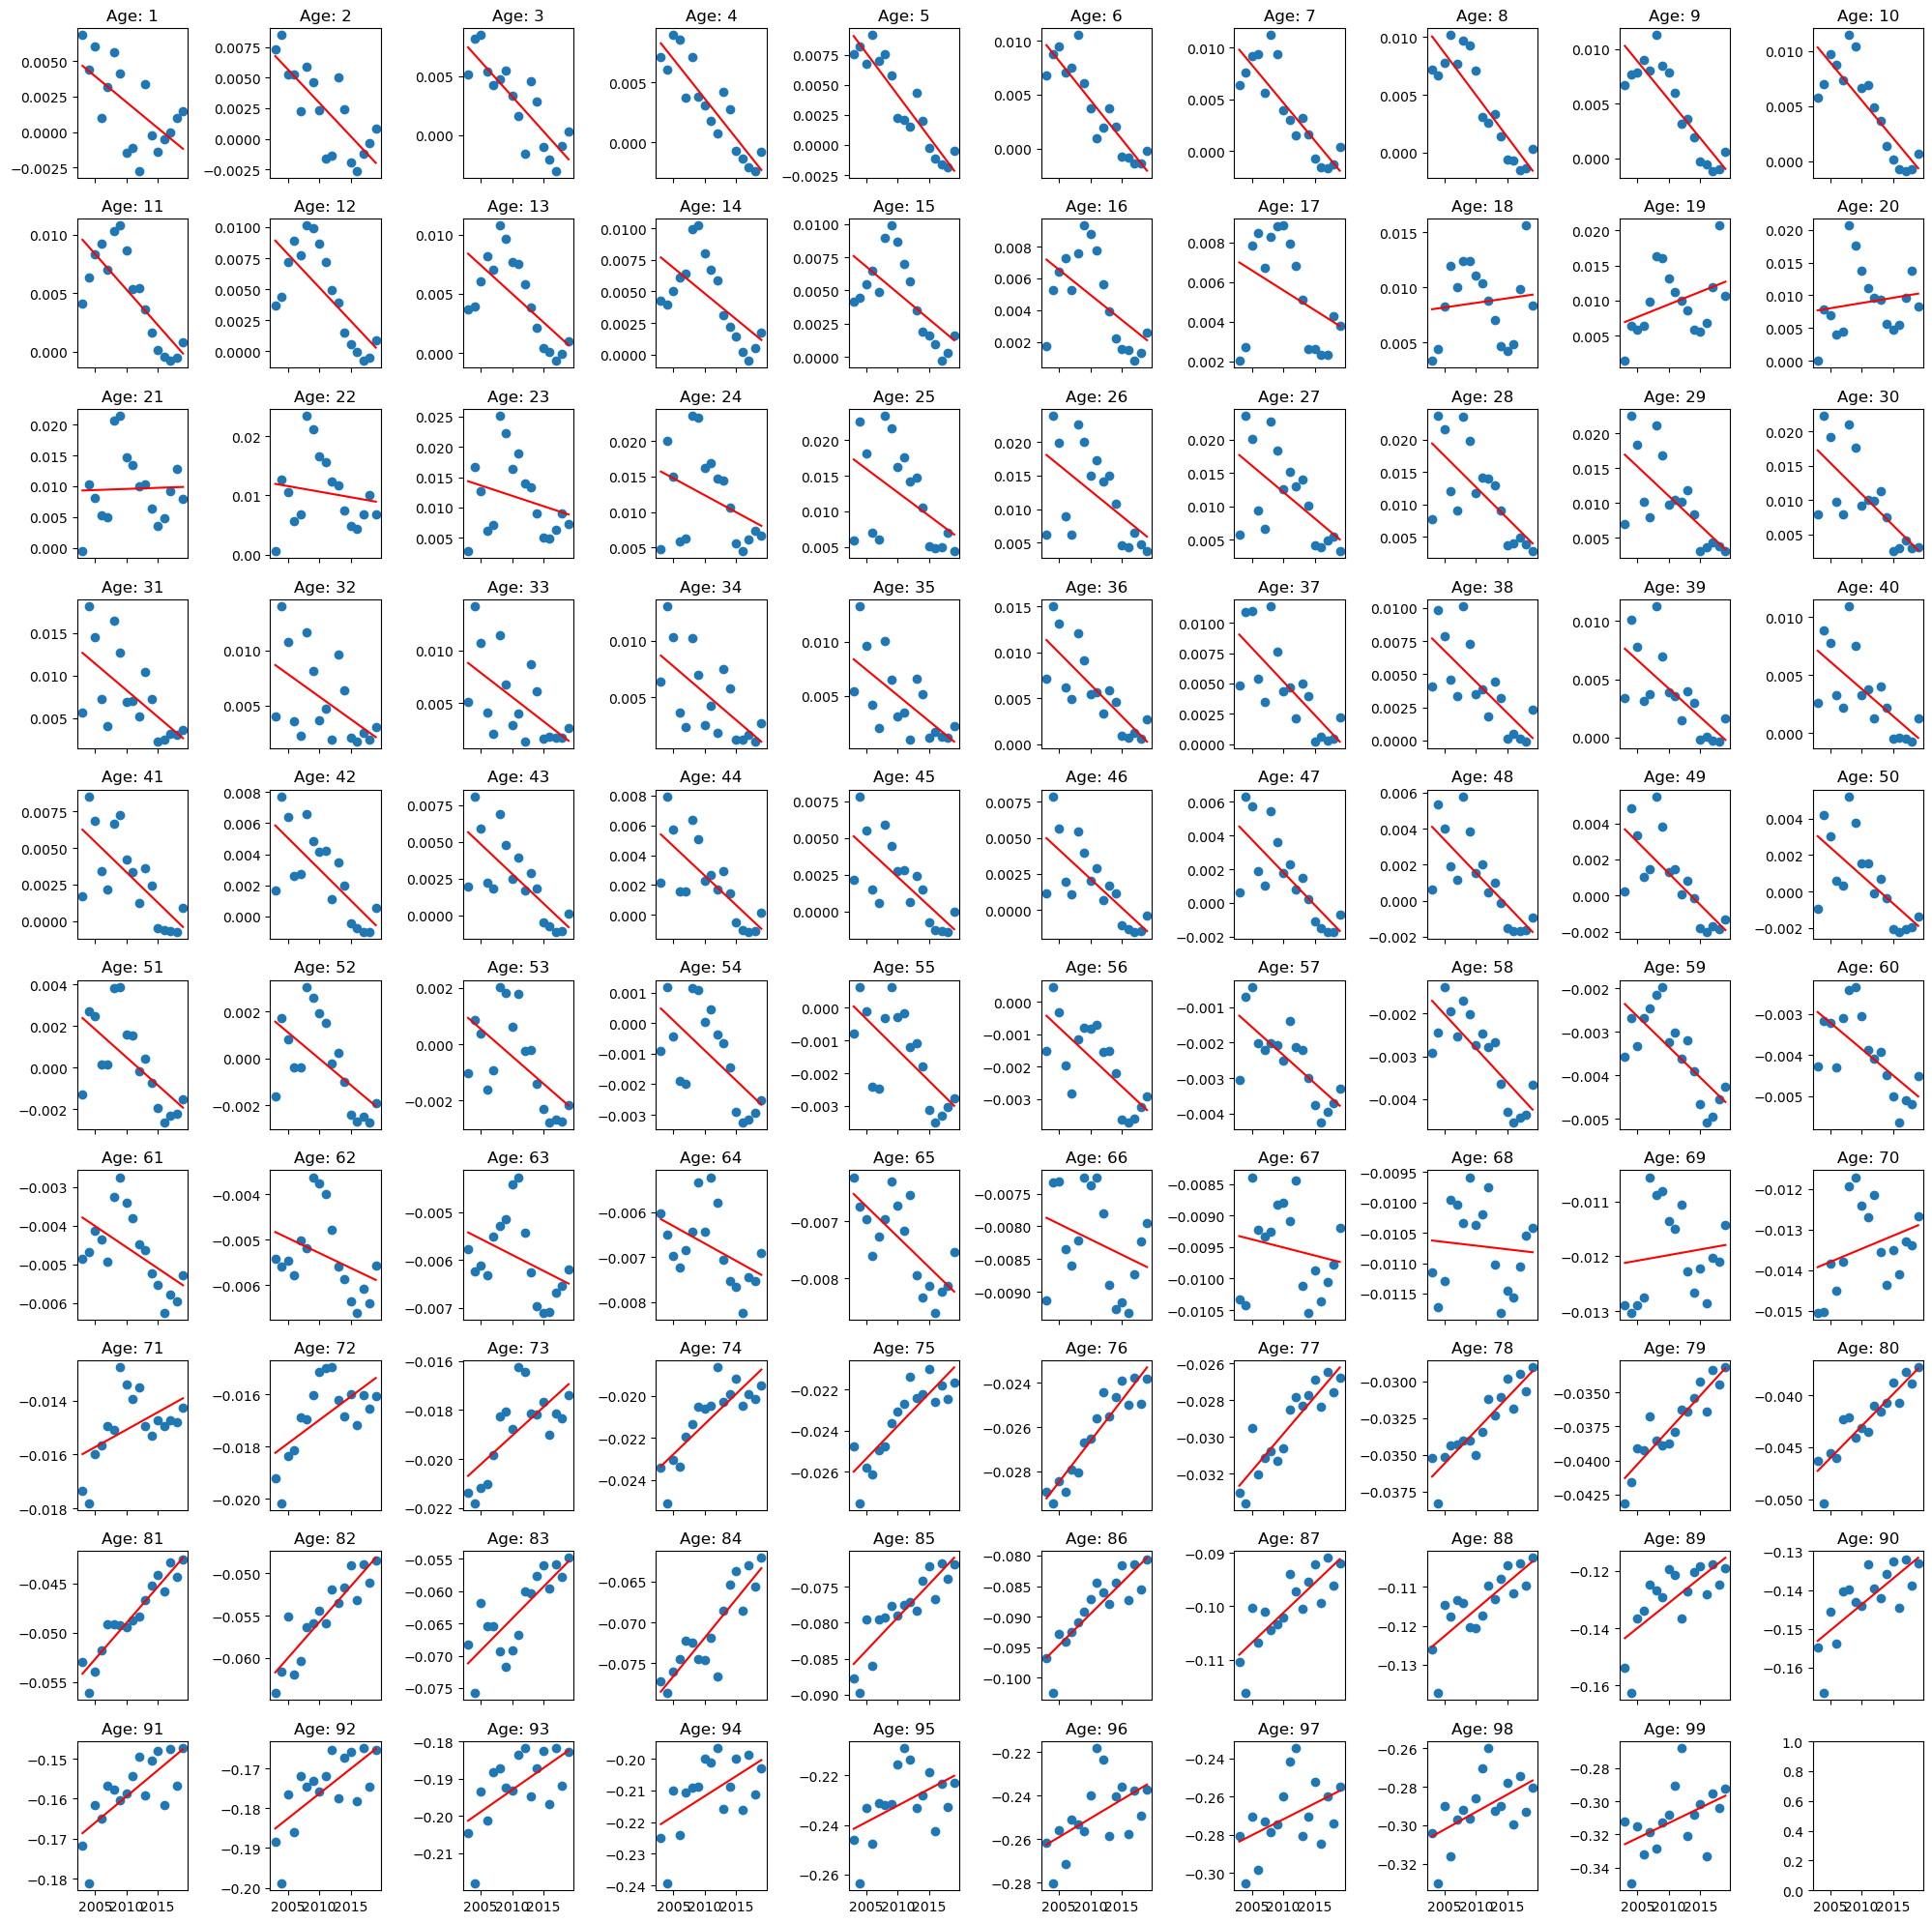

In [11]:
# Redo exactly the same thing but without sharing the y axis for better visualize the trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharey=False, sharex=True)
for i, age in enumerate(dfsr.index):
    ax = axs.flatten()[i]
    ax.scatter(dfsr.columns, dfsr.loc[age].values, label=age)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red")
    
plt.tight_layout()
plt.show()

In [12]:
# I can now use the coefficients to predict the survival rate for every age group and every year
# For example:
np.polyval(lr_sr_1_99.loc[age], range(2000,2101))

array([-0.33129679, -0.32947224, -0.32764769, -0.32582315, -0.3239986 ,
       -0.32217405, -0.3203495 , -0.31852495, -0.3167004 , -0.31487585,
       -0.31305131, -0.31122676, -0.30940221, -0.30757766, -0.30575311,
       -0.30392856, -0.30210401, -0.30027947, -0.29845492, -0.29663037,
       -0.29480582, -0.29298127, -0.29115672, -0.28933218, -0.28750763,
       -0.28568308, -0.28385853, -0.28203398, -0.28020943, -0.27838488,
       -0.27656034, -0.27473579, -0.27291124, -0.27108669, -0.26926214,
       -0.26743759, -0.26561305, -0.2637885 , -0.26196395, -0.2601394 ,
       -0.25831485, -0.2564903 , -0.25466575, -0.25284121, -0.25101666,
       -0.24919211, -0.24736756, -0.24554301, -0.24371846, -0.24189392,
       -0.24006937, -0.23824482, -0.23642027, -0.23459572, -0.23277117,
       -0.23094662, -0.22912208, -0.22729753, -0.22547298, -0.22364843,
       -0.22182388, -0.21999933, -0.21817478, -0.21635024, -0.21452569,
       -0.21270114, -0.21087659, -0.20905204, -0.20722749, -0.20

## Survival Rate 100+
Particular case because there is some "accumulation" of centenarians.

In [13]:
df100 = dfp.loc[[99,100], range(2002, 2020)].T
df100["sum"] = df100[99] + df100[100]
# make the survival rate the fraction of column "100" over the sum of columns "99" and "100" form the prvious year
df100["survival_rate"] = (df100[100] - df100["sum"].shift(1)) / df100["sum"].shift(1)
df100 = df100.drop(index=[2002])
df100

eta      99    100    sum  survival_rate
year                                    
2003   4702   7093  11795      -0.354419
2004   4971   7200  12171      -0.389572
2005   5411   8095  13506      -0.334894
2006   5682   8538  14220      -0.367837
2007   5945   9122  15067      -0.358509
2008   6643   9575  16218      -0.364505
2009   7469  10158  17627      -0.373659
2010   8547  11297  19844      -0.359108
2011   9207  13106  22313      -0.339548
2012  10791  15435  26226      -0.308251
2013  10705  16205  26910      -0.382102
2014  11153  17252  28405      -0.358900
2015  10728  18420  29148      -0.351523
2016   8258  17698  25956      -0.392823
2017   7145  16558  23703      -0.362074
2018   6689  14984  21673      -0.367844
2019   8985  14132  23117      -0.347944

array([-1.31992076e-05, -3.33074749e-01])

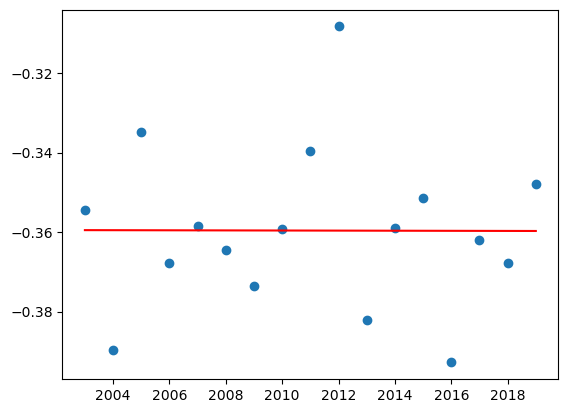

In [14]:
lr_sr_100p = np.polyfit(df100.index, df100["survival_rate"], 1)
display(lr_sr_100p)
# plot scatter and fit
plt.plot(df100.index, df100["survival_rate"], "o")
plt.plot(df100.index, np.polyval(lr_sr_100p, df100.index), color="red")
plt.show()

In [15]:
# Extrapolation to 2100
np.polyval(lr_sr_100p, range(2000,2101))

array([-0.35947316, -0.35948636, -0.35949956, -0.35951276, -0.35952596,
       -0.35953916, -0.35955236, -0.35956556, -0.35957876, -0.35959196,
       -0.35960516, -0.35961836, -0.35963155, -0.35964475, -0.35965795,
       -0.35967115, -0.35968435, -0.35969755, -0.35971075, -0.35972395,
       -0.35973715, -0.35975035, -0.35976355, -0.35977675, -0.35978995,
       -0.35980314, -0.35981634, -0.35982954, -0.35984274, -0.35985594,
       -0.35986914, -0.35988234, -0.35989554, -0.35990874, -0.35992194,
       -0.35993514, -0.35994834, -0.35996153, -0.35997473, -0.35998793,
       -0.36000113, -0.36001433, -0.36002753, -0.36004073, -0.36005393,
       -0.36006713, -0.36008033, -0.36009353, -0.36010673, -0.36011993,
       -0.36013312, -0.36014632, -0.36015952, -0.36017272, -0.36018592,
       -0.36019912, -0.36021232, -0.36022552, -0.36023872, -0.36025192,
       -0.36026512, -0.36027832, -0.36029151, -0.36030471, -0.36031791,
       -0.36033111, -0.36034431, -0.36035751, -0.36037071, -0.36

## Projection of population till 2100

In [16]:
br_df['Predict. (Stable)']

2002         NaN
2003         NaN
2004         NaN
2005         NaN
2006         NaN
          ...   
2096    400626.0
2097    400626.0
2098    400626.0
2099    400626.0
2100    400626.0
Name: Predict. (Stable), Length: 99, dtype: float64

In [17]:
dfpproj = dfp.copy()
for y in range(2023, 2101):
    dfpproj.loc[0, y] = br_df['Predict. (Stable)'][y]
    for age in range(1, 99+1):
        dfpproj.loc[age, y] = dfpproj.loc[age-1, y-1] * (1 + np.polyval(lr_sr_1_99.loc[age], y))
    dfpproj.loc[100, y] = (dfpproj.loc[99, y-1] + dfpproj.loc[100, y-1]) * (1 + np.polyval(lr_sr_100p, y))
dfpproj

year    2002    2003    2004    2005    2006    2007    2008    2009    2010  \
eta                                                                            
0     523007  535656  542323  558500  551127  556884  560700  570791  562322   
1     529233  526577  538020  545596  559067  552870  560028  563021  569963   
2     528131  533126  531043  540860  548487  560347  556146  562640  564317   
3     518790  530847  537507  535545  543768  550808  563000  559193  564536   
4     515957  522484  534064  542329  540131  545782  554754  565127  560899   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
96     16400   17254   17494   20055   21122   24346   25054   27290   28086   
97     10981   11797   11980   12758   14071   15356   17559   18179   20203   
98      6838    7643    7901    8505    8725    9888   10871   12349   12977   
99      4866    4702    4971    5411    5682    5945    6643    7469    8547   
100     6121    7093    7200    8095    8538    9122    9575   10158   11297   

year    2011  ...           2091           2092           2093           2094  \
eta           ...                                                               
0     553218  ...  400626.000000  400626.000000  400626.000000  400626.000000   
1     561694  ...  389630.054100  389483.844146  389337.634191  389191.424237   
2     569064  ...  373695.683506  373342.872512  372990.221101  372637.729272   
3     565219  ...  357264.677583  356705.395562  356146.685432  355588.546908   
4     565563  ...  339880.409611  339111.397589  338343.671805  337577.230850   
..       ...  ...            ...            ...            ...            ...   
96     29780  ...  190368.932927  190505.851715  193425.091383  195231.101838   
97     21305  ...  165548.057345  164627.434315  165063.428377  167915.253883   
98     14740  ...  145486.739507  141621.166395  141131.872837  141804.702478   
99      9207  ...  119268.448099  121708.629678  118733.234066  118580.519034   
100    13106  ...  206958.422607  208560.919156  211141.094556  210884.076468   

year           2095           2096           2097           2098  \
eta                                                                
0     400626.000000  400626.000000  400626.000000  400626.000000   
1     389045.214282  388899.004327  388752.794373  388606.584418   
2     372285.397025  371933.224362  371581.211280  371229.357782   
3     355030.979705  354473.983539  353917.558126  353361.703180   
4     336812.073314  336048.197790  335285.602871  334524.287150   
..              ...            ...            ...            ...   
96    198494.769981  199539.603899  204196.918411  202984.796678   
97    169808.545624  172978.133719  174221.302858  178628.094050   
98    144558.910891  146496.510930  149544.364847  150934.771469   
99    119404.567296  121987.462785  123889.815675  126740.189166   
100   210617.791104  210969.997782  212841.895573  215250.127567   

year           2099           2100  
eta                                 
0     400626.000000  400626.000000  
1     388460.374464  388314.164509  
2     370877.663866  370526.129532  
3     352806.418417  352251.703552  
4     333764.249221  333005.487679  
..              ...            ...  
96    203472.525799  208534.087037  
97    177906.142714  178672.819020  
98    155076.184935  154771.750847  
99    128193.959044  131994.344291  
100   218607.089375  221677.628334  

[101 rows x 99 columns]

In [18]:
pprojmelt = dfpproj.reset_index().melt(id_vars="eta", var_name="year", value_name="OBS_VALUE")
pprojmelt

eta  year      OBS_VALUE
0       0  2002  523007.000000
1       1  2002  529233.000000
2       2  2002  528131.000000
3       3  2002  518790.000000
4       4  2002  515957.000000
...   ...   ...            ...
9994   96  2100  208534.087037
9995   97  2100  178672.819020
9996   98  2100  154771.750847
9997   99  2100  131994.344291
9998  100  2100  221677.628334

[9999 rows x 3 columns]

In [19]:
fig = px.line(
    pprojmelt, 
    x="eta", 
    y="OBS_VALUE", 
    title=f"Total population in Italy by age group (TOTAL)",
    animation_frame="year",
    markers=False,
)
fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Population",
    # Set limits x axis between 2000 and 2025
    #xaxis_range=["2000-01-01", "2023-01-01"],
)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [20]:
dfpproj_sum = pd.DataFrame(
    dfpproj.sum(),
    columns=['Population']
).assign(Prediction=lambda x: x.index>=2023).reset_index().rename(columns={'index':'Year'})
dfpproj_sum

year    Population  Prediction
0   2002  5.699327e+07       False
1   2003  5.718638e+07       False
2   2004  5.761199e+07       False
3   2005  5.804437e+07       False
4   2006  5.828900e+07       False
..   ...           ...         ...
94  2096  2.109378e+07        True
95  2097  2.075168e+07        True
96  2098  2.041159e+07        True
97  2099  2.007296e+07        True
98  2100  1.973586e+07        True

[99 rows x 3 columns]

In [21]:
fig = px.line(
    dfpproj_sum,
    x="year",
    y="Population",
    color="Prediction", 
    title="Total population in Italy",
    markers=True,
)
fig.show()

## Conclusion
... I hope I made some mistake,

## Follow-up
- Consider the birth rate as a function of the amount of population in 20-45 range, so that the coefficient reflects better the "choice" of making chiledren for a couple
- Better test the statistical significance of the trend in  survival rate